In [124]:
using Dates
using Printf

using Gen
using OceanTurb

using JLD2
using Plots

In [2]:
#####
##### Load Oceananigans free convection data from JLD2 file
#####

file = jldopen("free_convection_profiles.jld2")

Is = keys(file["timeseries/t"])

Nz = file["grid/Nz"]
Lz = file["grid/Lz"]
Nt = length(Is)

t = zeros(Nt)
T = T_data = zeros(Nt, Nz)
wT = zeros(Nt, Nz)

for (i, I) in enumerate(Is)
    t[i] = file["timeseries/t/$I"]
    T[i, :] = file["timeseries/T/$I"][1, 1, 2:Nz+1]
end

┌ Info: Saved animation to 
│   fn = /home/alir/random-jupyter-notebooks/Gen/deepening_mixed_layer.gif
└ @ Plots /home/alir/.julia/packages/Plots/WwFyB/src/animation.jl:98


Plots.AnimatedGif("/home/alir/random-jupyter-notebooks/Gen/deepening_mixed_layer.gif")
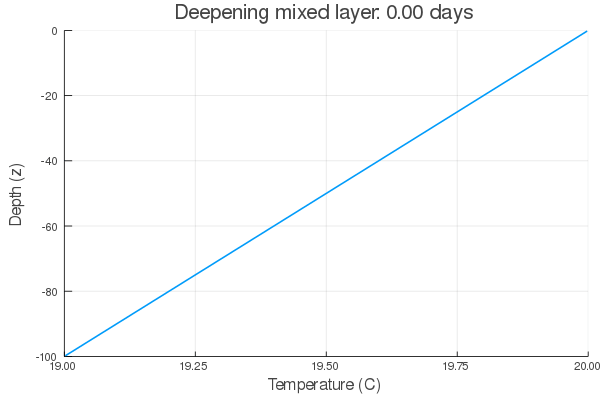

In [3]:
#####
##### Plot animation of T(z,t) from data
#####

zC = file["grid/zC"]

anim = @animate for n=1:10:Nt
    title = @sprintf("Deepening mixed layer: %.2f days", t[n] / 86400)
    plot(T[n, :], zC, linewidth=2,
         xlim=(19, 20), ylim=(-100, 0), label="",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title=title, show=false)
end

gif(anim, "deepening_mixed_layer.gif", fps=15)

In [4]:
# Code credit: https://github.com/sandreza/OceanConvectionUQSupplementaryMaterials/blob/master/src/utils.jl

"""
avg(Φ, n)
# Description
- Average a field down by n.
- Requires field to have evenly spaced points. Size of N leq length(Φ).
- Furthermore requires
# Arguments
- `Φ` :(vector) The field, an array
- `n` :(Int) number of grid points to average down to.
# Return
- `Φ2` :(vector) The field with values averaged, an array
"""
function avg(Φ, n)
    m = length(Φ)
    scale = Int(floor(m/n))
    if ( abs(Int(floor(m/n)) - m/n) > eps(1.0))
        return error
    end
    Φ2 = zeros(n)
    for i in 1:n
        Φ2[i] = 0
            for j in 1:scale
                Φ2[i] += Φ[scale*(i-1) + j] / scale
            end
    end
    return Φ2
end

avg

In [137]:
# Modified from: https://github.com/sandreza/OceanConvectionUQSupplementaryMaterials/blob/master/src/ForwardMap/fm.jl

"""
Generative model for free convection.
"""
@gen function free_convection_model(ℂ, constants, N, L, Δt, times, T₀, FT, ∂T∂z)
    # Uniform priors on all four KPP parameters.
    CSL  = @trace(uniform(0, 1), :CSL)
    CNL  = @trace(uniform(0, 8), :CNL)
    Cb_T = @trace(uniform(0, 6), :Cb_T)
    CKE  = @trace(uniform(0, 5), :CKE)
    
    parameters = KPP.Parameters(CSL=CSL, CNL=CNL, Cb_T=Cb_T, CKE=CKE)
    
    model = KPP.Model(N=N, L=L, stepper=:BackwardEuler, constants=constants, parameters=parameters)
    
    # Coarse grain initial condition from LES and set equal
    # to initial condition of parameterization.
    model.solution.T.data[1:N] .= avg(T₀, N)
    
    # Set boundary conditions
    model.bcs.T.top = FluxBoundaryCondition(FT)
    model.bcs.T.bottom = GradientBoundaryCondition(∂T∂z)
    
    Nt = length(times)
    solution = zeros(N, Nt)

    # loop the model
    for n in 1:Nt
        run_until!(model, Δt, times[n])
        @. solution[:, n] = model.solution.T[1:N]
    end
    
    # Put prior distributions on the temperature at every
    # grid point at every time step with some noise.
    noise = @trace(gamma(1, 1), :noise)
    for n in 1:Nt, i in 1:N
        @trace(normal(solution[i, n], noise), (:T, i, n))
    end
    
    return solution, model.grid.zc
end

free_convection_model

In [138]:
# Physical constants
ρ₀ = file["parameters/density"]
cₚ = file["parameters/specific_heat_capacity"]
f  = file["parameters/coriolis_parameter"]
α  = file["buoyancy/equation_of_state/α"]
β  = file["buoyancy/equation_of_state/β"]
g  = file["buoyancy/gravitational_acceleration"]

constants = Constants(Float64, ρ₀=ρ₀, cP=cₚ, f=f, α=α, β=β, g=g)

Constants{Float64}(9.80665, 4000.0, 1027.0, 0.000167, 0.0, 0.0001)

In [139]:
# OceanTurb parameters
N = 16
L = file["grid/Lz"]
Δt = 60

Q = parse(Float64, file["parameters/surface_cooling"])
FT = -Q / (ρ₀*cₚ)
∂T∂z = file["parameters/temperature_gradient"]

0.01

## Running the probabilistic program

In [140]:
ℂ = (1.0, 1.0, 1.0, 1.0)
Nt = 600
times = t[1:Nt]
T₀ = T[1, :]

trace = Gen.simulate(free_convection_model, (ℂ, constants, N, L, Δt, times, T₀, FT, ∂T∂z))

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Any, Any, Any, Any, Any, Any, Any, Any, Any], ##free_convection_model#1541, Bool[0, 0, 0, 0, 0, 0, 0, 0, 0], false), Trie{Any,Gen.ChoiceOrCallRecord}(Dict{Any,Gen.ChoiceOrCallRecord}((:T, 2, 429) => Gen.ChoiceOrCallRecord{Float64}(19.003733384331998, -0.8028677061192133, NaN, true),(:T, 13, 526) => Gen.ChoiceOrCallRecord{Float64}(19.551032700880654, -0.7997875138394974, NaN, true),(:T, 8, 243) => Gen.ChoiceOrCallRecord{Float64}(21.17732654733961, -2.6578264486398613, NaN, true),(:T, 3, 215) => Gen.ChoiceOrCallRecord{Float64}(18.60031478245479, -0.9946386105872592, NaN, true),(:T, 4, 281) => Gen.ChoiceOrCallRecord{Float64}(18.299203814100522, -1.336494642159915, NaN, true),(:T, 6, 284) => Gen.ChoiceOrCallRecord{Float64}(20.1359685224971, -1.1976147505118688, NaN, true),(:T, 8, 508) => Gen.ChoiceOrCallRecord{Float64}(20.72585138112849, -1.804666650148274, NaN, true),(:T, 16, 

In [141]:
choices = Gen.get_choices(trace)
@sprintf("Choices made: CSL=%.5f, CNL=%.5f, Cb_T=%.5f, CKE=%.5f",
         choices[:CSL], choices[:CNL], choices[:Cb_T], choices[:CKE])

"Choices made: CSL=0.92625, CNL=2.19382, Cb_T=3.61313, CKE=0.51903"

┌ Info: Saved animation to 
│   fn = /home/alir/random-jupyter-notebooks/Gen/deepening_mixed_layer_random_KPP_parameters.gif
└ @ Plots /home/alir/.julia/packages/Plots/WwFyB/src/animation.jl:98


Plots.AnimatedGif("/home/alir/random-jupyter-notebooks/Gen/deepening_mixed_layer_random_KPP_parameters.gif")
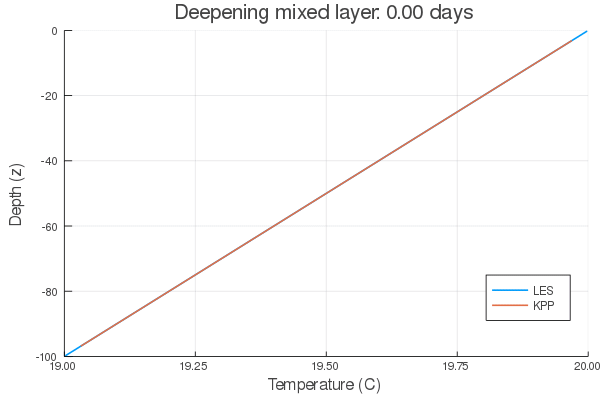

In [142]:
KPP_solution, KPP_zC = trace.retval

anim = @animate for n=1:Nt
    title = @sprintf("Deepening mixed layer: %.2f days", t[n] / 86400)
    plot(T[n, :], zC, linewidth=2,
         xlim=(19, 20), ylim=(-100, 0), label="LES",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title=title, legend=:bottomright, show=false)
    
    plot!(KPP_solution[:, n], KPP_zC, linewidth=2, label="KPP")
end

gif(anim, "deepening_mixed_layer_random_KPP_parameters.gif", fps=15)

## Posterior inference!

In [143]:
T_cs = T_coarse_grained = zeros(Nt, N)
for n in 1:Nt
    T_cs[n, :] .= avg(T[n, :], N)
end

In [144]:
function do_inference(model, model_args, data, samples)
    # Create a choice map that maps model addresses (:T, i, n)
    # to observed data T[i, n]. We leave the four KPP parameters
    # (:CSL, :CNL, :Cb_T, :CKE) unconstrained, because we want them
    # to be inferred.
    observations = Gen.choicemap()
    
    Nt, N = size(data)
    for n in 1:Nt, i in 1:N
        observations[(:T, i, n)] = data[n, i]
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    trace, lml_est = Gen.importance_resampling(model, model_args, observations, samples)
    
    return trace
end

do_inference (generic function with 1 method)

In [152]:
N_traces = 20
N_samples = 500

model_args = (ℂ, constants, N, L, Δt, times, T₀, FT, ∂T∂z)

traces = []
for i in 1:N_traces
    @printf("[%s] Trace #%d/%d\n", now(), i, N_traces); flush(stdout);
    push!(traces, do_inference(free_convection_model, model_args, T_coarse_grained, N_samples))
end

[2020-02-08T17:36:20.357] Trace #1/20
[2020-02-08T17:39:22.376] Trace #2/20
[2020-02-08T17:42:27.68] Trace #3/20
[2020-02-08T17:45:30.618] Trace #4/20
[2020-02-08T17:48:38.327] Trace #5/20
[2020-02-08T17:51:42.009] Trace #6/20
[2020-02-08T17:54:45.87] Trace #7/20
[2020-02-08T17:57:47.424] Trace #8/20
[2020-02-08T18:00:47.134] Trace #9/20
[2020-02-08T18:03:46.042] Trace #10/20
[2020-02-08T18:06:44.123] Trace #11/20
[2020-02-08T18:09:52.899] Trace #12/20
[2020-02-08T18:12:57.389] Trace #13/20
[2020-02-08T18:16:03.608] Trace #14/20
[2020-02-08T18:19:15.352] Trace #15/20
[2020-02-08T18:22:13.719] Trace #16/20
[2020-02-08T18:25:23.346] Trace #17/20
[2020-02-08T18:28:22.845] Trace #18/20
[2020-02-08T18:31:24.104] Trace #19/20
[2020-02-08T18:34:22.409] Trace #20/20


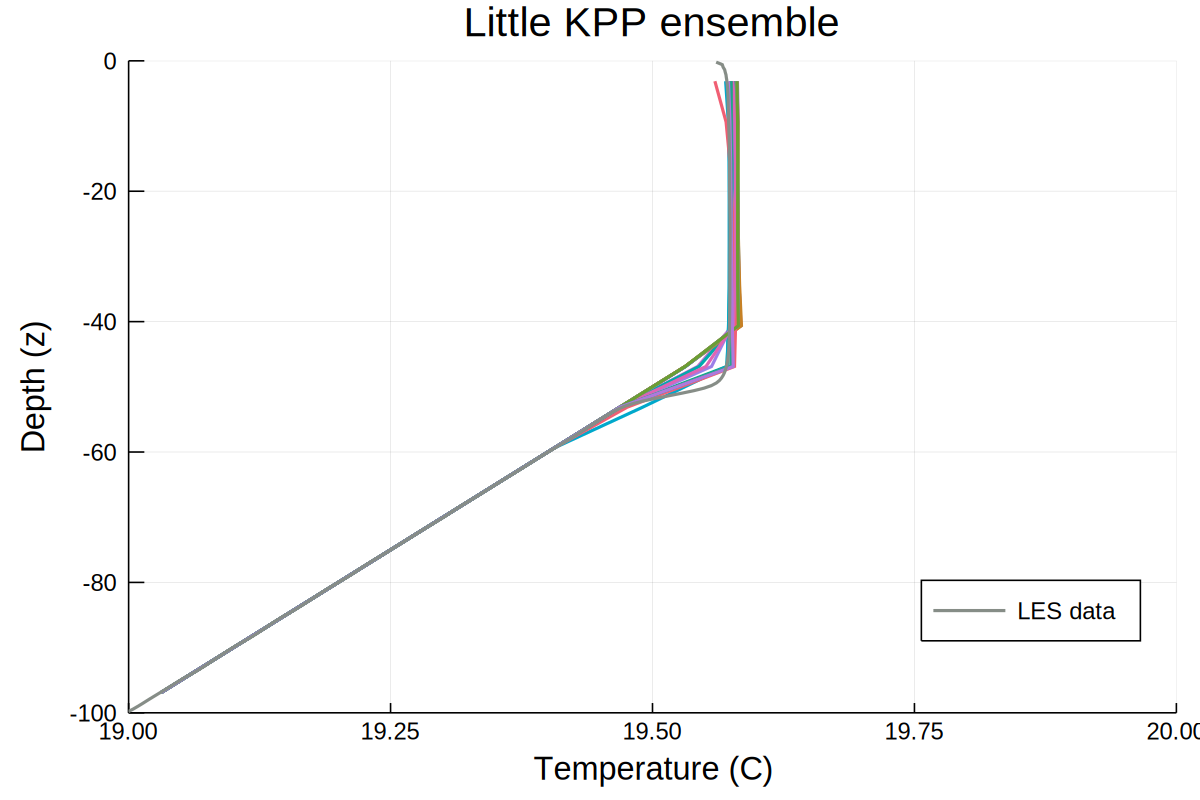

In [153]:
KPP_solution, KPP_zC = traces[1].retval
p = plot(KPP_solution[:, end], KPP_zC, linewidth=2,
         xlim=(19, 20), ylim=(-100, 0), label="",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title="Little KPP ensemble", dpi=200, show=false)

for i in 2:length(traces)
    KPP_solution, KPP_zC = traces[i].retval
    plot!(p, KPP_solution[:, end], KPP_zC, linewidth=2, label="")
end

plot!(p, T[Nt, :], zC, linewidth=2, label="LES data", legend=:bottomright)

display(p)

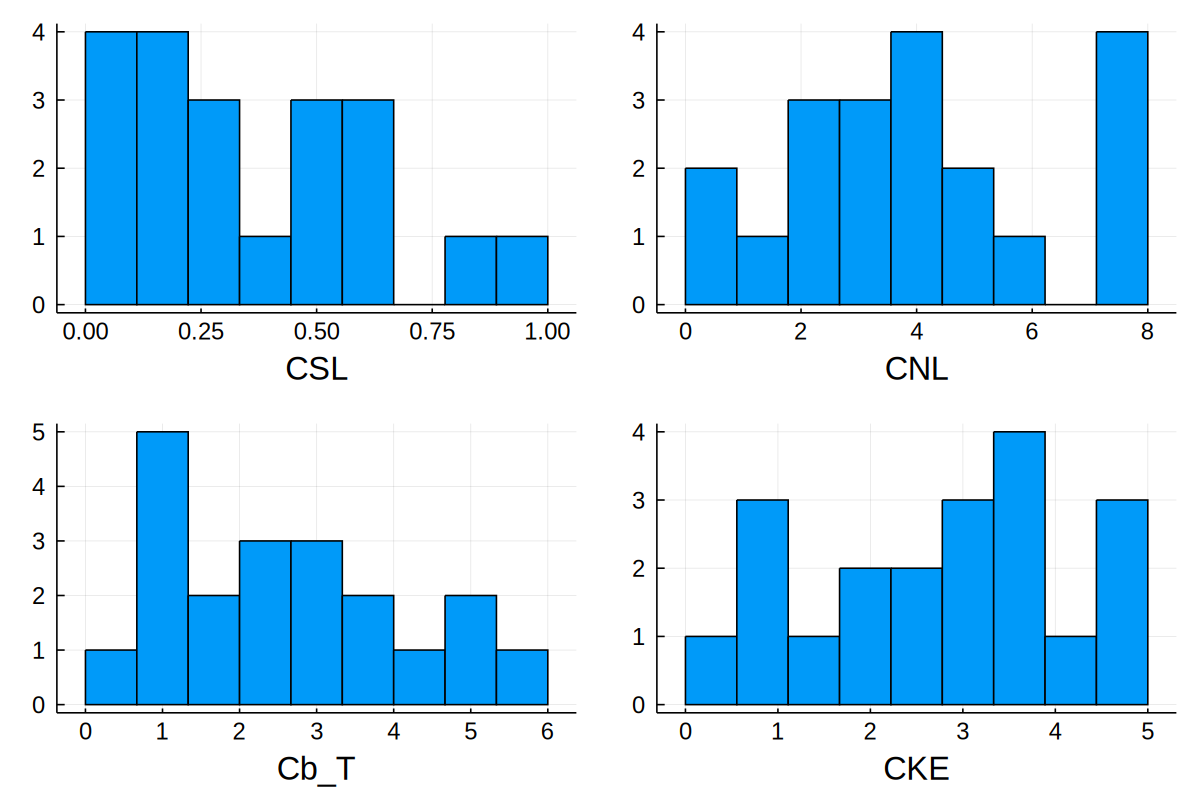

In [154]:
N_traces = length(traces)
CSL  = zeros(N_traces)
CNL  = zeros(N_traces)
Cb_T = zeros(N_traces)
CKE  = zeros(N_traces)

for (i, trace) in enumerate(traces)
    choices = Gen.get_choices(trace)
    CSL[i]  = choices[:CSL]
    CNL[i]  = choices[:CNL]
    Cb_T[i] = choices[:Cb_T]
    CKE[i]  = choices[:CKE]
end

CSL_hist = histogram(CSL,  bins=range(0, 1, length=10), xlabel="CSL",  label="")
CNL_hist = histogram(CNL,  bins=range(0, 8, length=10), xlabel="CNL",  label="")
CbT_hist = histogram(Cb_T, bins=range(0, 6, length=10), xlabel="Cb_T", label="")
CKE_hist = histogram(CKE,  bins=range(0, 5, length=10), xlabel="CKE",  label="")

plot(CSL_hist, CNL_hist, CbT_hist, CKE_hist, layout=(2,2), dpi=200)